# 1. Set up and load the data

In [1]:
# Imports.

import time
from functools import partial
from multiprocessing import Pool, cpu_count, shared_memory
from typing import Dict, Optional, Tuple

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm

In [2]:
# Define dataset name.

# DATASET = 'adamson_2016_pilot_curated'
# DATASET = 'adamson_2016_upr_epistasis_curated'
# DATASET = 'adamson_2016_upr_perturb_seq_curated'
# DATASET = 'datlinger_2017_curated'
DATASET = 'orion_2025_hct116_curated'
# DATASET = 'orion_2025_hek293t_curated'

In [3]:
# Copy dataset from storage.

# ! gsutil cp gs://perturbation-catalogue-lake/perturbseq/curated/{DATASET}.h5ad {DATASET}.h5ad

In [4]:
# Load the h5ad file.

adata = sc.read_h5ad(f'{DATASET}.h5ad', backed="r")

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# FIX: adata.var index structure.

adata.var.drop(columns=['gene_symbol'], inplace=True)
adata.var.index.name = 'gene_symbol'
adata.var.reset_index(inplace=True)
adata.var.set_index('gene_symbol', inplace=True)
adata.var['gene_symbol'] = adata.var.index

In [6]:
# FIX: downsample controls.

adata.obs['perturbed_target_symbol'] = adata.obs['perturbed_target_symbol'].str.replace(r'^control.*', 'control', regex=True).astype("category")

# 2. Data investigations

In [7]:
# Check that any given row can be quickly accessed.

adata.X[42]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6259 stored elements and shape (1, 38606)>

In [8]:
# Overview of the file.

adata

AnnData object with n_obs × n_vars = 3409169 × 38606 backed at 'orion_2025_hct116_curated.h5ad'
    obs: 'perturbation_name', 'perturbed_target_coord', 'perturbed_target_number', 'perturbed_target_ensg', 'perturbed_target_symbol', 'perturbed_target_biotype', 'guide_sequence', 'perturbation_type_label', 'perturbation_type_id', 'timepoint', 'treatment_label', 'treatment_id', 'model_system_label', 'model_system_id', 'species', 'tissue_label', 'tissue_id', 'cell_type_label', 'cell_type_id', 'cell_line_label', 'cell_line_id', 'sex_label', 'sex_id', 'developmental_stage_label', 'developmental_stage_id', 'disease_label', 'disease_id'
    var: 'ensembl_gene_id', 'gene_symbol'

In [9]:
# High level look at the observations.

adata.obs

,perturbation_name,perturbed_target_coord,perturbed_target_number,perturbed_target_ensg,perturbed_target_symbol,perturbed_target_biotype,guide_sequence,perturbation_type_label,perturbation_type_id,timepoint,...,cell_type_label,cell_type_id,cell_line_label,cell_line_id,sex_label,sex_id,developmental_stage_label,developmental_stage_id,disease_label,disease_id
0,ST14_P1P2-1|ST14_P1P2-2,chr11:130159782-130210362;1,1,ENSG00000149418,ST14,protein_coding,GGCCCAGCGCGCCCGACCGG|GAGAGAGCGCGCCAGGGCGA,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
1,SIGLEC5_P1P2-1|SIGLEC5_P1P2-2,chr19:51630101-51645545;-1,1,ENSG00000105501,SIGLEC5,lncRNA,GCCCGAGGCCCTGACTCCCA|GTATGGGACCTGGTGACCTC,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
2,VSNL1_P1P2-1|VSNL1_P1P2-2,chr2:17539126-17657018;1,1,ENSG00000163032,VSNL1,protein_coding,GTGCAAGGCGCGATCCAAGA|GGATTTACCCGAGCGTGTTG,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
3,KCNK7_P1P2-1|KCNK7_P1P2-2,chr11:65592836-65595996;-1,1,ENSG00000173338,KCNK7,protein_coding,GAAGGCCCTGGTCCCGATAC|GAGTTCCCACAGCACCCCAG,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
4,APOA4_P1P2-1|APOA4_P1P2-2,chr11:116820700-116823304;-1,1,ENSG00000110244,APOA4,protein_coding,GGCGCAGGTGAGCTCTCCTG|GTTGTAGGGAGGATCCAGTG,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409164,ACP6_P1P2-1|ACP6_P1P2-2,chr1:147629652-147670524;-1,1,ENSG00000162836,ACP6,protein_coding,GAGACCCCGAGTGGGAACGG|GCCTGAGGGAGACCCCGAGT,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
3409165,RNF39_P1P2-1|RNF39_P1P2-2,chr6:30070266-30075849;-1,1,ENSG00000204618,RNF39,protein_coding,GTGAAGAGAGAGGCAATCCC|GGGCAATCCCAGGAGAGGGG,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
3409166,AFP_P2-1|AFP_P2-2,chr4:73431138-73456174;1,1,ENSG00000081051,AFP,protein_coding,GTCCGACGAGGTCAGCTGGG|GATGGCCATCAGCTCCGACG,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032
3409167,METTL9_P1P2-1|METTL9_P1P2-2,chr16:21597218-21657471;1,1,ENSG00000197006,METTL9,protein_coding,GGCGATGGCTCGAGCTCGGG|GGCCCATCCAGCCCCCTTCA,CRISPRi,NaN,P0DT0H0M0S,...,colon epithelial cell,CL:0011108,HCT 116 cell,CLO:0003665,male,NaN,adult,NaN,colon carcinoma,MONDO:0002032


In [10]:
# High level look at the genes.

adata.var

,ensembl_gene_id,gene_symbol
gene_symbol,,
DDX11L2,ENSG00000236397,DDX11L2
MIR1302-2HG,ENSG00000243485,MIR1302-2HG
FAM138A,ENSG00000237613,FAM138A
ENSG00000290826,ENSG00000290826,ENSG00000290826
OR4F5,ENSG00000186092,OR4F5
...,...,...
ENSG00000277836,NaN,ENSG00000277836
ENSG00000278633,NaN,ENSG00000278633
ENSG00000276017,NaN,ENSG00000276017


# 3. Perturbed genes statistics

Total number of distinct perturbed genes: 17776
First 10 perturbed genes: ['ST14', 'SIGLEC5', 'VSNL1', 'KCNK7', 'APOA4', 'SBF2', 'SLC39A8', 'CDK5RAP2', 'CHKA', 'ASB12']


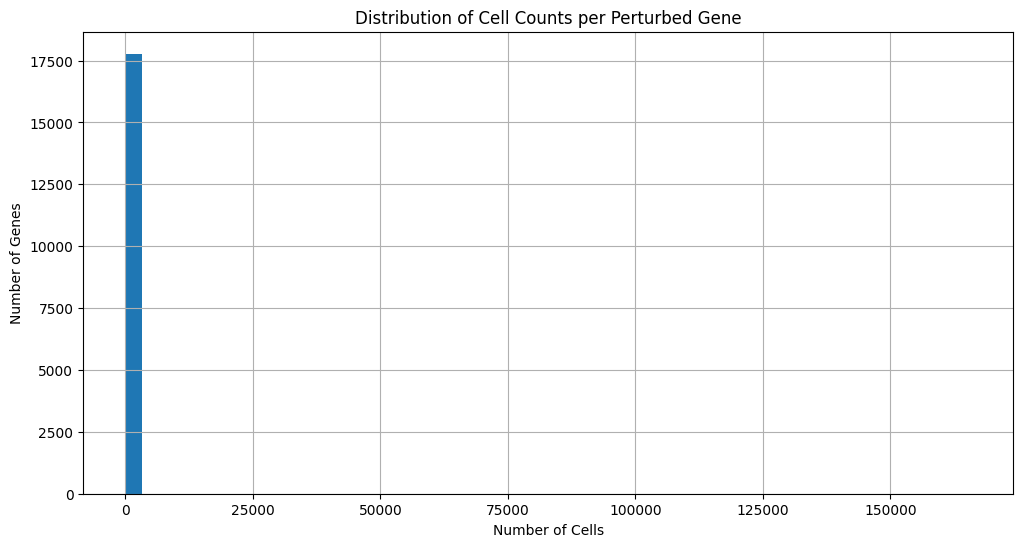


Statistics of cells per perturbed gene:
count     17777.000000
mean        191.639365
std        1248.684886
min           1.000000
25%          88.000000
50%         153.000000
75%         246.000000
max      165777.000000
Name: count, dtype: float64


In [11]:
# Get all unique perturbation targets (including 'control')
all_targets = adata.obs['perturbed_target_symbol'].unique()

# Filter out 'control' to get only perturbed genes
perturbed_targets = [t for t in all_targets if t != 'control']
num_perturbed_genes = len(perturbed_targets)

print(f"Total number of distinct perturbed genes: {num_perturbed_genes}")
print("First 10 perturbed genes:", perturbed_targets[:10])

# Count number of cells per perturbed gene
target_counts = adata.obs['perturbed_target_ensg'].value_counts()

# Remove 'control' from the counts for plotting
perturbation_counts = target_counts[target_counts.index != 'control']

# Plot histogram
plt.figure(figsize=(12, 6))
perturbation_counts.hist(bins=50)
plt.title('Distribution of Cell Counts per Perturbed Gene')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.grid(True)
plt.show()

# Show some statistics
print("\nStatistics of cells per perturbed gene:")
print(perturbation_counts.describe())

# 4. Cell type statistics

Total number of distinct cell types: 1
All cell types: ['colon epithelial cell']
Categories (1, object): ['colon epithelial cell']


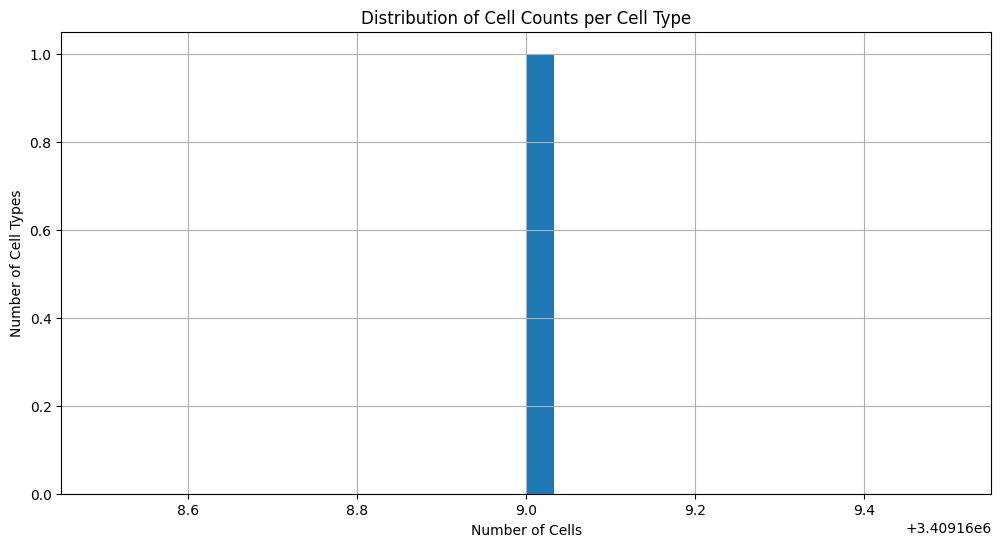

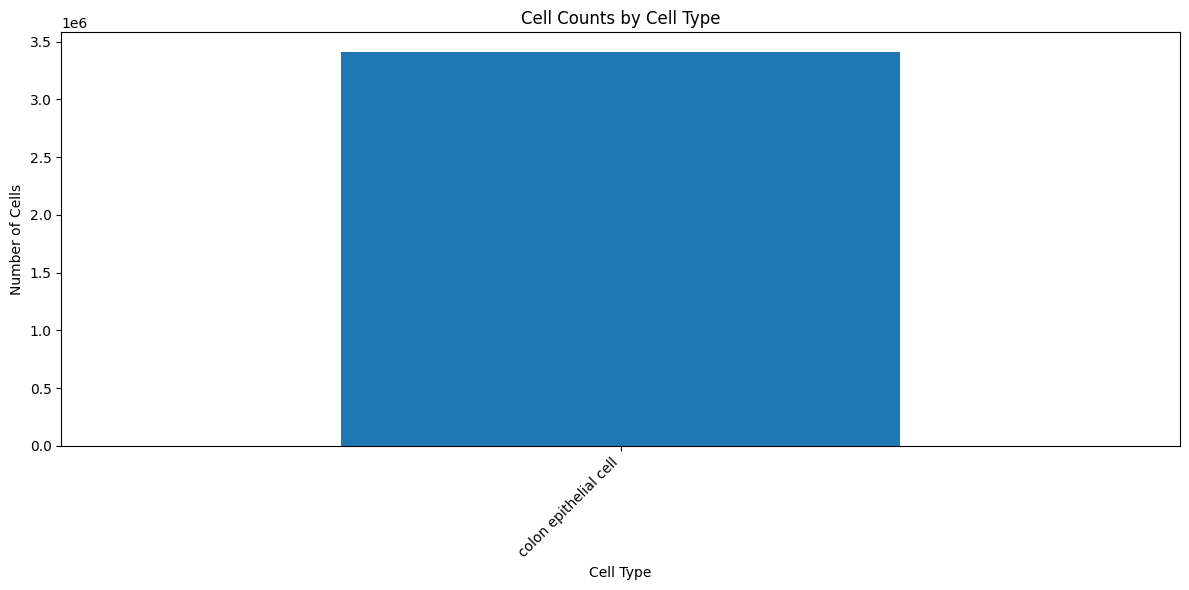


Statistics of cells per cell type:
count          1.0
mean     3409169.0
std            NaN
min      3409169.0
25%      3409169.0
50%      3409169.0
75%      3409169.0
max      3409169.0
Name: count, dtype: float64

Complete cell type distribution:
cell_type_label
colon epithelial cell    3409169
Name: count, dtype: int64


In [12]:
# Get all unique cell types
cell_types = adata.obs['cell_type_label'].unique()
num_cell_types = len(cell_types)

print(f"Total number of distinct cell types: {num_cell_types}")
print("All cell types:", cell_types)

# Count number of cells per cell type
cell_type_counts = adata.obs['cell_type_label'].value_counts()

# Plot histogram
plt.figure(figsize=(12, 6))
cell_type_counts.hist(bins=30)
plt.title('Distribution of Cell Counts per Cell Type')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Cell Types')
plt.grid(True)
plt.show()

# Plot as bar chart for better readability
plt.figure(figsize=(12, 6))
cell_type_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Cell Counts by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show some statistics
print("\nStatistics of cells per cell type:")
print(cell_type_counts.describe())

# Show the complete distribution
print("\nComplete cell type distribution:")
print(cell_type_counts)

# 5. Levels of expression of control genes

# 6. Pseudobulk differential expression

In [13]:
import pandas as pd
import numpy as np
import time
from anndata import AnnData
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
import os

def compute_pseudobulk_perturbation_analysis(
    adata: AnnData,
    output_csv_path: str,
    perturbation_col: str = "perturbed_target_symbol",
    cell_type_col: str = "cell_type_label",
    control_label: str = "control",
    min_cells_per_group: int = 10,
    log_transform: bool = True,
    chunk_size: int = 10000,
    min_expression_threshold: float = 10.0,
    debug_chunks: int = None,
    debug_perturbations: int = None
) -> None:
    """
    Compute pseudobulk analysis for perturbation data using a highly efficient single-pass,
    chunked approach with fully pre-allocated NumPy matrices for statistics storage.

    This function iterates through the data once, updating pre-allocated NumPy matrices
    that store summary statistics (count, sum, and sum of squares) for each valid
    perturbation group. It avoids pandas.groupby within the processing loop and uses
    vectorized index mapping for maximum speed and memory stability.

    Parameters:
    -----------
    adata : AnnData
        Annotated data object with perturbation expression results, ideally in backed mode.
    output_csv_path : str
        Path to the output CSV file where results will be saved.
    perturbation_col : str
        Column name in adata.obs containing perturbation target symbols.
    cell_type_col : str
        Column name in adata.obs containing cell type or cell line labels.
    control_label : str
        Label used for control/non-targeting samples.
    min_cells_per_group : int
        Minimum number of cells required per perturbation group within each cell type.
    log_transform : bool
        Whether to log1p-transform the data before analysis. The function will attempt
        to automatically skip transformation if data appears to be already logged.
    chunk_size : int
        Number of cells to process in each chunk during the single pass.
    min_expression_threshold : float
        Minimum total pseudobulk control expression to include a gene in the analysis.
    debug_chunks : int, optional
        If set, process only the first N chunks for quick debugging. Defaults to None.
    debug_perturbations : int, optional
        If set, process only the first N perturbations per cell type. Defaults to None.

    Returns:
    --------
    None
        Results are saved directly to the specified CSV file.
    """
    start_time = time.time()
    print("🚀 Starting single-pass pseudobulk analysis...")

    # --- 1. Initial validation and setup ---
    if perturbation_col not in adata.obs.columns:
        raise ValueError(f"Perturbation column '{perturbation_col}' not found in adata.obs")
    if cell_type_col not in adata.obs.columns:
        raise ValueError(f"Cell type column '{cell_type_col}' not found in adata.obs")

    # --- 2. Pre-computation: Identify valid groups and fully pre-allocate storage ---
    print("📊 Pre-processing: Identifying valid groups and allocating memory for stats...")
    obs_filtered = adata.obs[[cell_type_col, perturbation_col]].dropna()
    
    group_counts = obs_filtered.groupby([cell_type_col, perturbation_col]).size()
    valid_groups = group_counts[group_counts >= min_cells_per_group]
    
    if not any(control_label in pert for _, pert in valid_groups.index):
        raise ValueError(f"Control label '{control_label}' not found in any group meeting the minimum cell threshold.")

    # Create mappings from group labels to a unique integer index for matrix rows
    valid_group_tuples = valid_groups.index
    group_to_idx = {group: i for i, group in enumerate(valid_group_tuples)}
    idx_to_group = {i: group for i, group in enumerate(valid_group_tuples)}
    num_valid_groups = len(valid_groups)
    
    # Pre-allocate NumPy matrices for all stats. This is the most memory- and speed-efficient way.
    n_counts = valid_groups.values.astype(np.int32)
    sum_x_matrix = np.zeros((num_valid_groups, adata.n_vars), dtype=np.float64)
    sum_x_sq_matrix = np.zeros((num_valid_groups, adata.n_vars), dtype=np.float64)

    print(f"  ✓ Found {num_valid_groups} valid groups meeting the {min_cells_per_group} cell threshold.")
    print(f"  ✓ Fully pre-allocated NumPy matrices to store statistics.")

    # --- 3. Single-Pass Data Aggregation ---
    print("\n🏎️  Performing single pass over the data to collect statistics...")
    if debug_chunks is not None:
        print(f"⚠️ [DEBUG MODE] Will process a maximum of {debug_chunks} chunk(s).")

    is_log_transformed = not log_transform
    first_chunk_X = adata.X[:min(chunk_size, adata.n_obs), :]
    if log_transform and np.max(first_chunk_X) > 20:
        print("  ✓ Detected high expression values. Applying log1p transformation.")
        is_log_transformed = True
    else:
        print("  ✓ Data appears to be already logged or log_transform=False. Skipping transformation.")

    chunk_counter = 0
    for start in tqdm(range(0, adata.n_obs, chunk_size), desc="Processing Chunks", unit="chunk"):
        if debug_chunks is not None and chunk_counter >= debug_chunks:
            print(f"\n[DEBUG] Processed the first {debug_chunks} chunks. Halting data aggregation.")
            break

        end = min(start + chunk_size, adata.n_obs)
        obs_chunk = adata.obs.iloc[start:end]
        
        expression_data = adata.X[start:end, :]
        if hasattr(expression_data, 'toarray'):
            X_chunk = np.asarray(expression_data.toarray())
        else:
            X_chunk = np.asarray(expression_data)
        
        if is_log_transformed:
            # Perform log-transform in-place to save memory
            np.log1p(X_chunk, out=X_chunk)

        # Vectorized mapping of cells to their matrix row index. This is much faster than groupby.
        # Use -1 for cells not in any valid group.
        group_keys = zip(obs_chunk[cell_type_col], obs_chunk[perturbation_col])
        chunk_group_indices = np.array([group_to_idx.get(key, -1) for key in group_keys], dtype=np.int32)

        # Iterate over unique matrix indices present in the chunk, avoiding groupby overhead
        unique_indices_in_chunk = np.unique(chunk_group_indices)
        for matrix_idx in unique_indices_in_chunk:
            if matrix_idx == -1:
                continue # Skip cells that are not part of a valid group

            # Use a boolean mask to select all cells for the current group
            mask = (chunk_group_indices == matrix_idx)
            X_group_chunk = X_chunk[mask, :]
            
            # Update matrices using fast, direct integer indexing
            sum_x_matrix[matrix_idx, :] += np.sum(X_group_chunk, axis=0)
            sum_x_sq_matrix[matrix_idx, :] += np.sum(np.square(X_group_chunk), axis=0)
        
        chunk_counter += 1

    # --- 4. Post-Pass Calculation and Output ---
    print("\n🔬 All statistics collected. Calculating differential expression...")
    print(f"📦 Streaming results directly to: {output_csv_path}")
    
    output_dir = os.path.dirname(output_csv_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    analyzed_cell_types = set()
    analyzed_perturbations = set()
    total_comparisons = 0
    
    # Organize groups by cell type for structured processing
    groups_by_cell_type = {}
    for idx, (cell_type, pert) in idx_to_group.items():
        if cell_type not in groups_by_cell_type:
            groups_by_cell_type[cell_type] = []
        groups_by_cell_type[cell_type].append({'pert': pert, 'idx': idx})

    with open(output_csv_path, 'w') as f_out:
        header = "cell_type_label,perturbation,gene,log2fc,pvalue,padj,mean_control,mean_perturbed\n"
        f_out.write(header)
        
        for cell_type, pert_info_list in groups_by_cell_type.items():
            control_info = next((p for p in pert_info_list if p['pert'] == control_label), None)

            if control_info is None:
                print(f"  ⚠️ Skipping {cell_type}: control group not found or did not meet cell threshold.")
                continue
            
            print(f"\n--- Analyzing {cell_type} ---")
            
            control_idx = control_info['idx']
            n_control = n_counts[control_idx]
            
            sum_x_c_full = sum_x_matrix[control_idx, :]
            
            threshold_to_use = np.log1p(min_expression_threshold) if is_log_transformed else min_expression_threshold
            expressed_genes_mask = sum_x_c_full > threshold_to_use
            
            if not np.any(expressed_genes_mask):
                print(f"  ⚠️ No genes passed expression threshold. Skipping.")
                continue

            sum_x_c = sum_x_c_full[expressed_genes_mask]
            sum_x_sq_c = sum_x_sq_matrix[control_idx, :][expressed_genes_mask]
            
            mean_c = sum_x_c / n_control
            var_c = (sum_x_sq_c - (np.square(sum_x_c) / n_control)) / (n_control - 1)
            var_c[var_c <= 0] = 1e-12 

            perturbations_to_process = sorted([p for p in pert_info_list if p['pert'] != control_label], key=lambda x: x['pert'])
            if debug_perturbations is not None and len(perturbations_to_process) > debug_perturbations:
                print(f"  ⚠️ [DEBUG MODE] Analyzing only the first {debug_perturbations} perturbations for {cell_type}.")
                perturbations_to_process = perturbations_to_process[:debug_perturbations]

            for pert_info in tqdm(perturbations_to_process, desc="  Perturbations", unit="pert"):
                pert = pert_info['pert']
                pert_idx = pert_info['idx']
                
                n_pert = n_counts[pert_idx]
                sum_x_p = sum_x_matrix[pert_idx, :][expressed_genes_mask]
                sum_x_sq_p = sum_x_sq_matrix[pert_idx, :][expressed_genes_mask]
                
                mean_p = sum_x_p / n_pert
                var_p = (sum_x_sq_p - (np.square(sum_x_p) / n_pert)) / (n_pert - 1)
                var_p[var_p <= 0] = 1e-12

                with np.errstate(divide='ignore', invalid='ignore'):
                    _, pvalues = stats.ttest_ind_from_stats(
                        mean1=mean_p, std1=np.sqrt(var_p), nobs1=n_pert,
                        mean2=mean_c, std2=np.sqrt(var_c), nobs2=n_control,
                        equal_var=False
                    )
                pvalues = np.nan_to_num(pvalues, nan=1.0)
                
                _, padj, _, _ = multipletests(pvalues, method='fdr_bh')
                
                pseudocount = 1e-8
                log2fc = np.log2((mean_p + pseudocount) / (mean_c + pseudocount))
                
                pert_results = pd.DataFrame({
                    'cell_type_label': cell_type,
                    'perturbation': pert,
                    'gene': adata.var_names[expressed_genes_mask],
                    'log2fc': log2fc,
                    'pvalue': pvalues,
                    'padj': padj,
                    'mean_control': mean_c,
                    'mean_perturbed': mean_p
                })
                
                analyzed_cell_types.add(cell_type)
                analyzed_perturbations.add(pert)
                total_comparisons += len(pert_results)

                pert_results.to_csv(f_out, header=False, index=False)

    # --- 5. Final Summary ---
    print("\n\n📋 Finalizing summary...")
    
    total_time = time.time() - start_time
    print(f"\n🎉 Analysis complete! Total time: {total_time:.2f} seconds")
    print(f"   Analyzed {len(analyzed_cell_types)} cell types")
    print(f"   Analyzed {len(analyzed_perturbations)} unique perturbations")
    print(f"   Total comparisons written to file: {total_comparisons:,}")

In [ ]:
# Run the analysis

results = compute_pseudobulk_perturbation_analysis(
    adata,
    f"{DATASET}.csv",
    perturbation_col="perturbed_target_symbol",
    control_label="control",
    min_cells_per_group=10,
    chunk_size=10000,  # Process 10000 cells per chunk
    min_expression_threshold=10.0,  # Only analyze genes with control expression > 10
    # debug_chunks=100,
    # debug_perturbations=100,
)

🚀 Starting single-pass pseudobulk analysis...
📊 Pre-processing: Identifying valid groups and allocating memory for stats...
  ✓ Found 17549 valid groups meeting the 10 cell threshold.
  ✓ Fully pre-allocated NumPy matrices to store statistics.

🏎️  Performing single pass over the data to collect statistics...


/var/tmp/ipykernel_3321/1769449560.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = obs_filtered.groupby([cell_type_col, perturbation_col]).size()


  ✓ Detected high expression values. Applying log1p transformation.


Processing Chunks:   0%|          | 0/341 [00:00<?, ?chunk/s]


🔬 All statistics collected. Calculating differential expression...
📦 Streaming results directly to: orion_2025_hct116_curated.csv

--- Analyzing colon epithelial cell ---


  Perturbations:   0%|          | 0/17548 [00:00<?, ?pert/s]

In [ ]:
# Upload to Google Storage.
! gsutil -m cp {DATASET}.csv gs://perturbation-catalogue-lake/perturbseq/differential_expression/{DATASET}.csv

# 7. Volcano plots (not currently used)

In [ ]:
def plot_volcano_plot(results_df, perturbation_name, 
                     pval_threshold=0.05, fc_threshold=1.0, 
                     top_n_genes=10):
    """
    Create a volcano plot for a specific perturbation.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from compute_pseudobulk_perturbation_analysis
    perturbation_name : str
        Name of the perturbation to plot
    pval_threshold : float
        P-value threshold for significance
    fc_threshold : float
        Fold change threshold (absolute log2 fold change)
    top_n_genes : int
        Number of top genes to label
    """
    import matplotlib.pyplot as plt
    
    # Filter for specific perturbation
    pert_data = results_df[results_df['perturbation'] == perturbation_name].copy()
    
    if len(pert_data) == 0:
        print(f"No data found for perturbation: {perturbation_name}")
        print(f"Available perturbations: {results_df['perturbation'].unique()}")
        return
    
    # Remove rows with NaN values for plotting
    pert_data = pert_data.dropna(subset=['padj', 'log2fc'])
    
    if len(pert_data) == 0:
        print(f"No valid data points for perturbation: {perturbation_name} after removing NaN values")
        return
    
    print(f"Plotting {len(pert_data)} genes for {perturbation_name}")
    
    # Create significance categories
    pert_data['significant'] = (pert_data['padj'] < pval_threshold) & (np.abs(pert_data['log2fc']) > fc_threshold)
    
    print(f"Found {np.sum(pert_data['significant'])} significant genes")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot non-significant points
    non_sig = pert_data[~pert_data['significant']]
    if len(non_sig) > 0:
        ax.scatter(non_sig['log2fc'], -np.log10(non_sig['padj']), 
                  alpha=0.5, color='gray', s=20, label=f'Non-significant ({len(non_sig)})')
    
    # Plot significant points
    sig = pert_data[pert_data['significant']]
    if len(sig) > 0:
        ax.scatter(sig['log2fc'], -np.log10(sig['padj']), 
                  alpha=0.7, color='red', s=30, label=f'Significant ({len(sig)})')
    
    # Add threshold lines
    ax.axhline(-np.log10(pval_threshold), color='blue', linestyle='--', alpha=0.5, 
               label=f'padj = {pval_threshold}')
    ax.axvline(fc_threshold, color='blue', linestyle='--', alpha=0.5)
    ax.axvline(-fc_threshold, color='blue', linestyle='--', alpha=0.5)
    
    # Label top genes (by most significant padj)
    top_genes = pert_data.nsmallest(top_n_genes, 'padj')
    for _, gene in top_genes.iterrows():
        if not np.isnan(gene['padj']) and gene['padj'] > 0:  # Only label if valid padj
            ax.annotate(gene['gene'], 
                       (gene['log2fc'], -np.log10(gene['padj'])),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)
    
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_title(f'Volcano Plot: {perturbation_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add some statistics to the plot
    stats_text = f"Total genes: {len(pert_data)}\n"
    stats_text += f"Significant: {np.sum(pert_data['significant'])}\n"
    stats_text += f"FC threshold: ±{fc_threshold}\n"
    stats_text += f"padj threshold: {pval_threshold}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print(f"\nSummary for {perturbation_name}:")
    print(f"  Total genes plotted: {len(pert_data)}")
    print(f"  Significant genes: {np.sum(pert_data['significant'])}")
    print(f"  Mean |log2FC|: {np.mean(np.abs(pert_data['log2fc'])):.3f}")
    print(f"  Min padj: {np.min(pert_data['padj']):.2e}")
    if len(sig) > 0:
        print(f"  Top significant gene: {sig.loc[sig['padj'].idxmin(), 'gene']} (padj={sig['padj'].min():.2e})")